In [9]:
import numpy as np # for linear algebra
import pandas as pd # for data visuals and analysis
import keras # for nearual nets and training
import tensorflow as tf # for neaural nets and training
import matplotlib.pyplot as plt # for data visualization
import dicom # to read dicom files 
import zipfile as zf
from sklearn.datasets import load_files    
from keras.utils import np_utils
import cv2 
import os

Load dataset from train directory

In [155]:
train_dir = "C:\\Users\\Aditya Pratap\\MY MACHINE LEARNING\\Kaggle Plant Seedlings Classification\\train"

def load_dataset(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return plant_files, plant_targets

def load_dir(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    return plant_files

train_files, train_targets = load_dataset('train')

n_classes = train_targets

dir_list = load_dir(train_dir)

Organize images and get all their diemnsions

In [4]:
from PIL import Image

train_images = []
img_class = []
img_height = []
img_width = []
dir_list = load_dir(train_dir)

for c, files in zip(n_classes, dir_list):    
        img = Image.open(files)
        train_images.append(img)        
        img_class.append(files)
        img_height.append(img.height)
        img_width.append(img.width)
df_all = pd.DataFrame({"class": img_class, "height": img_height, "width": img_width}, index = train_images)

df_all.head()

,class,height,width
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=98x98 at 0x1FE0457E3C8>,C:\Users\Aditya Pratap\MY MACHINE LEARNING\Kag...,98,98
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=178x178 at 0x1FE045DCCC0>,C:\Users\Aditya Pratap\MY MACHINE LEARNING\Kag...,178,178
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=410x410 at 0x1FE045E9C50>,C:\Users\Aditya Pratap\MY MACHINE LEARNING\Kag...,410,410
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=209x209 at 0x1FE045E9CC0>,C:\Users\Aditya Pratap\MY MACHINE LEARNING\Kag...,209,209
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=190x190 at 0x1FE045E9D30>,C:\Users\Aditya Pratap\MY MACHINE LEARNING\Kag...,190,190


## Pre Process Image

In [14]:
#IMAGE MASKING
def plant_mask(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#IMAGE SEGMENTING
def seg_plant(image):
    mask = plant_mask(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

#SHARPENING THE SEGMENTED IMAGE
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [271]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mask_images = [] #Store all masked images
sharpened_images = [] #Store all sharpened images
segmented_images = [] #Store all segmented images
original_images = [] # Store all original resized images
labels = [] # Store all labels

width = 400
height = 400
img_size = 250


for i in dir_list: #For i in number of images
    
    image = cv2.imread(i) #Read every image using cv2.imread()
    
    head, tail = os.path.split(os.path.split(i)[0])#Take the path of the image, split it and the name of the class is tail
    
    labels.append(tail) #append the name of the class to labels
    
    resized = cv2.resize(image, (img_size, img_size)) #Resize every image to 50 by 50
    
    image_mask = plant_mask(resized)  
    image_segmented = seg_plant(resized)
    image_sharpen = sharpen_image(image_segmented)
    mask_images.append(image_mask)
    sharpened_images.append(image_sharpen)
    segmented_images.append(image_segmented)
    original_images.append(resized)
    

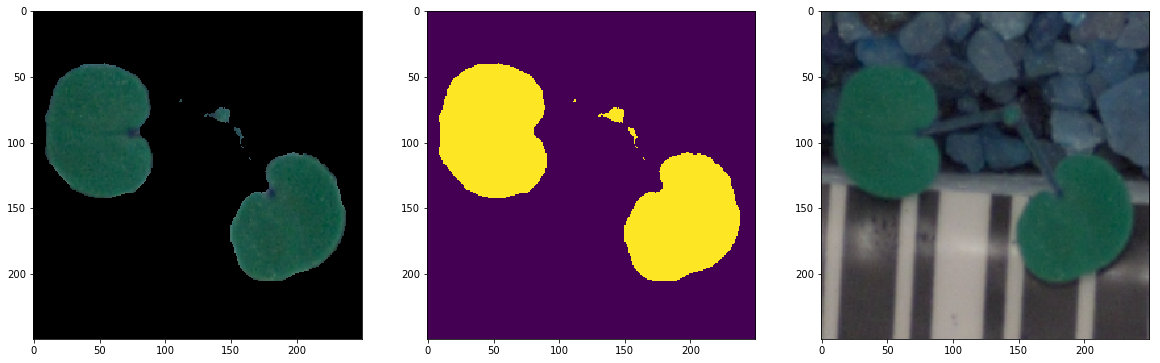

Maize


In [272]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(sharpened_images[3])
axs[1].imshow(mask_images[3])
axs[2].imshow(original_images[3])
plt.show()
print(labels[5])

## Organize

Save images to local folder to avoid re-pre-processing which consumes a lot of time.

In [147]:
path_sharpened = 'C:\\Users\\Aditya Pratap\\Desktop\\Machine Learning\\Pre-processed Images\\sharpened images'

a = -1
for x in (sharpened_images):
    cv2.imwrite(os.path.join(path_sharpened, 'image' + str(a+1) + '.png'), x)
    a = a+1


In [197]:
#Bring the saved images in folder and save the images in train_segmented_images array to use in model
image_dir = 'C:\\Users\\Aditya Pratap\\Desktop\\Machine Learning\\Pre-processed Images\\sharpened images'

file_dir = load_dir(image_dir)

train_segmented_images = [] #save the sharpened, segmented images to this array
for x in file_dir:
        im = cv2.imread(x)
        train_segmented_images.append(im)

print(len(train_segmented_images))

4750


##### Binarize Lables so model does not take words but binarized numbers

In [273]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer().fit(labels)
label = lb.transform(labels)
print(label)

[[0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [274]:
from sklearn.cross_validation import train_test_split

#Training and validation split ---> using np_sharpened_images for training images
x_train, x_valid, y_train, y_valid = train_test_split(sharpened_images, label, test_size = 0.05, random_state = 42)


In [275]:
print(len(x_train))

4512


In [278]:
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
tf.reset_default_graph()

LR = 0.001

convnet = input_data(shape=[None, img_size, img_size, 3], name='input')

convnet = conv_2d(convnet, 64, 4, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 4, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 256, 4, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 4, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 4, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 12, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



In [280]:
model.fit({'input': x_train}, {'targets': y_train}, n_epoch=8, validation_set=({'input': x_valid}, {'targets': y_valid}), 
    snapshot_step=500, show_metric=True, run_id="plant")

Training Step: 584  | total loss: 0.31160 | time: 716.424s
| Adam | epoch: 009 | loss: 0.31160 - acc: 0.9176 -- iter: 4480/4512
Training Step: 585  | total loss: 0.30731 | time: 739.847s
| Adam | epoch: 009 | loss: 0.30731 - acc: 0.9134 | val_loss: 0.60836 - val_acc: 0.8109 -- iter: 4512/4512
--


In [269]:
import glob

test_dir = "C:\\Users\\Aditya Pratap\\MY MACHINE LEARNING\\Kaggle Plant Seedlings Classification\\test"

sharpened_image_test = []
test_labels = []
for filename in glob.glob('C:\\Users\\Aditya Pratap\\MY MACHINE LEARNING\\Kaggle Plant Seedlings Classification\\test/*.png'): #assuming gif
    im = cv2.imread(filename)
    resized_test = cv2.resize(im, (50, 50))
    image_segmented_test = seg_plant(resized_test)
    image_sharpen_test = sharpen_image(image_segmented_test)
    sharpened_image_test.append(image_sharpen_test)
    head, tail = os.path.split(os.path.split(filename)[1])
    test_labels.append(tail)
    
x_test = sharpened_image_test
yhat = model.predict(x_test)
test_y = lb.inverse_transform(yhat)
print((test_labels[56]))


126a71ce0.png


In [238]:
 print(test_y)

['Small-flowered Cranesbill' 'Common wheat' 'Sugar beet' 'Common Chickweed'
 'Sugar beet' 'Black-grass' 'Common Chickweed' 'Fat Hen' 'Common wheat'
 'Loose Silky-bent' 'Common Chickweed' 'Small-flowered Cranesbill'
 'Scentless Mayweed' 'Fat Hen' 'Fat Hen' 'Fat Hen' 'Scentless Mayweed'
 'Fat Hen' 'Common Chickweed' 'Shepherds Purse' 'Common Chickweed'
 'Small-flowered Cranesbill' 'Shepherds Purse' 'Sugar beet' 'Sugar beet'
 'Maize' 'Fat Hen' 'Scentless Mayweed' 'Shepherds Purse' 'Fat Hen'
 'Common Chickweed' 'Shepherds Purse' 'Black-grass' 'Sugar beet'
 'Loose Silky-bent' 'Black-grass' 'Sugar beet' 'Loose Silky-bent'
 'Common Chickweed' 'Maize' 'Fat Hen' 'Black-grass' 'Common Chickweed'
 'Small-flowered Cranesbill' 'Sugar beet' 'Sugar beet' 'Maize'
 'Scentless Mayweed' 'Maize' 'Small-flowered Cranesbill' 'Loose Silky-bent'
 'Fat Hen' 'Cleavers' 'Black-grass' 'Maize' 'Fat Hen' 'Cleavers'
 'Small-flowered Cranesbill' 'Cleavers' 'Black-grass' 'Sugar beet'
 'Cleavers' 'Charlock' 'Black-gras

The prediction for the first image below is Small-flowered Cranesbill


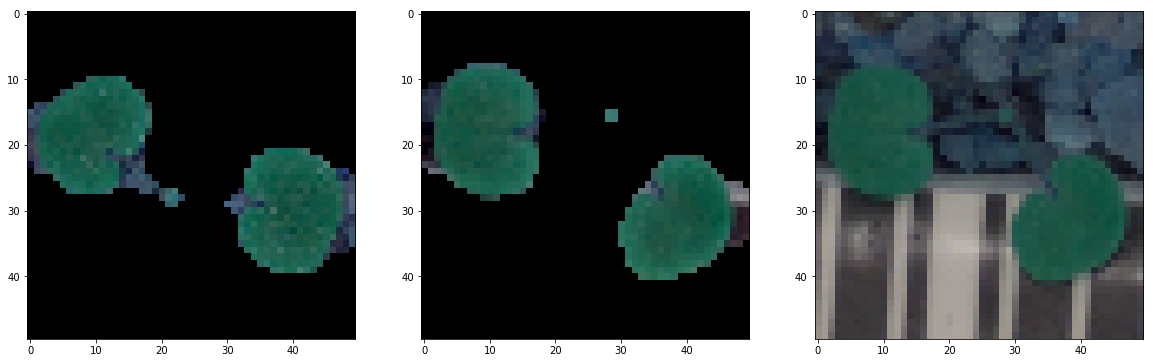

In [246]:
#FOR TESTING, I AM GOING TO USE SMALL-FLOWERED CRANESBILL AS A COMPARISION

print("The prediction for the first image below is", test_y[0]) #Prediction for test set image number 1

fig, axs = plt.subplots(1, 3, figsize=(20, 20))

axs[0].imshow(x_test[0]) #Test image number 1

axs[1].imshow(sharpened_images[3]) #Segmented Image from train set that is labelled Small-flowered Cranesbill

axs[2].imshow(original_images[3]) #original, non-preprocessed Small-flowered Cranesbill from train set itself to show 
                                  #what Small-flowered Cranesbill looks like

plt.show() #IF ALL THE IMAGES BELOW LOOK SIMILAR AND ARE LABELLED SMALL-FLOWER CRANESBILL, 
          #THEN THE MODEL HAS PREDICTED CORRECTLY!
    

In [256]:
import pandas as pd

In [270]:
df = pd.DataFrame(data={'file': test_labels, 'species': test_y})
df_sort = df.sort_values(by=['file'])
df_sort.to_csv('results.csv', index=False)